In [6]:
import glob
import re

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from utils import Graph
from mpl_toolkits.mplot3d import Axes3D
import itertools

file_tree = {}
for i in range(1, 100):  
    for file in glob.glob(f'simulation-runs/500V_{i}.txt'):
        key = int(re.search(r'(\d+)', file).group(1))
        if key in file_tree:
            file_tree[key].append(file)
        else:
            file_tree[key] = [file]



## Initial Coordinates of Electrons

In [7]:
# Initialize lists to store initial x, y, z coordinates
initial_x = []
initial_y = []
initial_z = []

# Function to extract initial coordinates from a file
def extract_initial_coordinates(file):
    with open(file, 'r') as f:
        # Assuming the first line contains the x, y, z coordinates in columns 2, 3, and 4
        line = f.readline().strip()
        # Split by comma and convert to float, filtering out any empty strings
        columns = list(map(float, filter(None, line.split(','))))
        x, y, z = columns[1], columns[2], columns[3]
        return x, y, z

# Process each group of files and extract initial coordinates
for key, value in sorted(file_tree.items()):
    print(key)
    group = Graph(value)
    
    # Extract initial coordinates from each file in the group
    for file in value:
        x, y, z = extract_initial_coordinates(file)
        initial_x.append(x)
        initial_y.append(y)
        initial_z.append(z)

# Convert lists to numpy arrays
initial_x = np.array(initial_x)
initial_y = np.array(initial_y)
initial_z = np.array(initial_z)

# Print or use the arrays as needed
print("Initial X coordinates:", initial_x)
print("Initial Y coordinates:", initial_y)
print("Initial Z coordinates:", initial_z)

500
Initial X coordinates: [-0.402243   0.516689  -0.461822  -0.171436  -0.0578016 -0.400735
  0.22898    0.230552   0.115513  -0.400987   0.515971   0.517107
  0.344881   0.231047  -0.0561667 -0.116742   0.0568197  0.171742
 -0.113627  -0.458679 ]
Initial Y coordinates: [ 1.03296e-04  5.06523e-04 -1.65372e-03  8.85887e-05  2.47361e-03
 -1.05067e-03 -5.92986e-04 -3.51149e-04  8.53234e-04 -1.54008e-03
 -9.97116e-04 -1.01494e-03  1.32012e-04 -6.35841e-05 -1.21524e-03
  1.24889e-03 -1.53432e-03 -1.38850e-03 -2.87128e-04 -4.22828e-06]
Initial Z coordinates: [-0.3377     0.433883  -0.384636  -0.142699  -0.0486571 -0.338866
  0.19332    0.1926     0.0965222 -0.337674   0.435076   0.433551
  0.289464   0.19294   -0.048813  -0.0953074  0.0482841  0.1435
 -0.0953092 -0.384998 ]


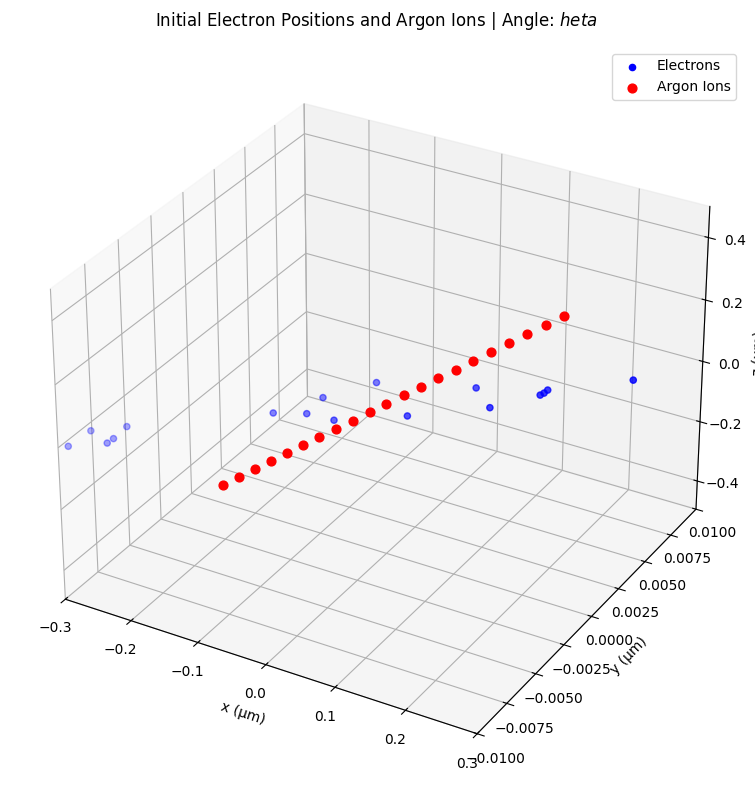

In [8]:
# ---------- user knobs ----------------------------------------------------
r_k_nm      = 50       # lattice spacing, nm
angle_deg   = 60     # tilt angle: 0° = +x axis, 90° = +z axis
# -------------------------------------------------------------------------

spacing_um  = r_k_nm / 1000.0                # nm → µm
rad         = np.deg2rad(angle_deg)          # degrees → radians
cosA, sinA  = np.cos(rad), np.sin(rad)

indices     = np.arange(-10, 11)             # 21 ions (−10 … +10)

# ion coordinates
lattice_x   = indices * spacing_um * cosA
lattice_y   = np.zeros_like(lattice_x)
lattice_z   = indices * spacing_um * sinA



fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(initial_x, initial_y, initial_z,
           s=20, c='blue',  depthshade=True,  label='Electrons')
ax.scatter(lattice_x, lattice_y, lattice_z,
           s=40, c='red',   depthshade=False, label='Argon Ions')

ax.set_title('Initial Electron Positions and Argon Ions | Angle: $\theta$', pad=15)
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_zlabel('z (µm)')

# nice z-limits
z_min = min(lattice_z.min(), initial_z.min())
z_max = max(lattice_z.max(), initial_z.max())


ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.01, 0.01)
ax.legend()
plt.tight_layout()
plt.show()



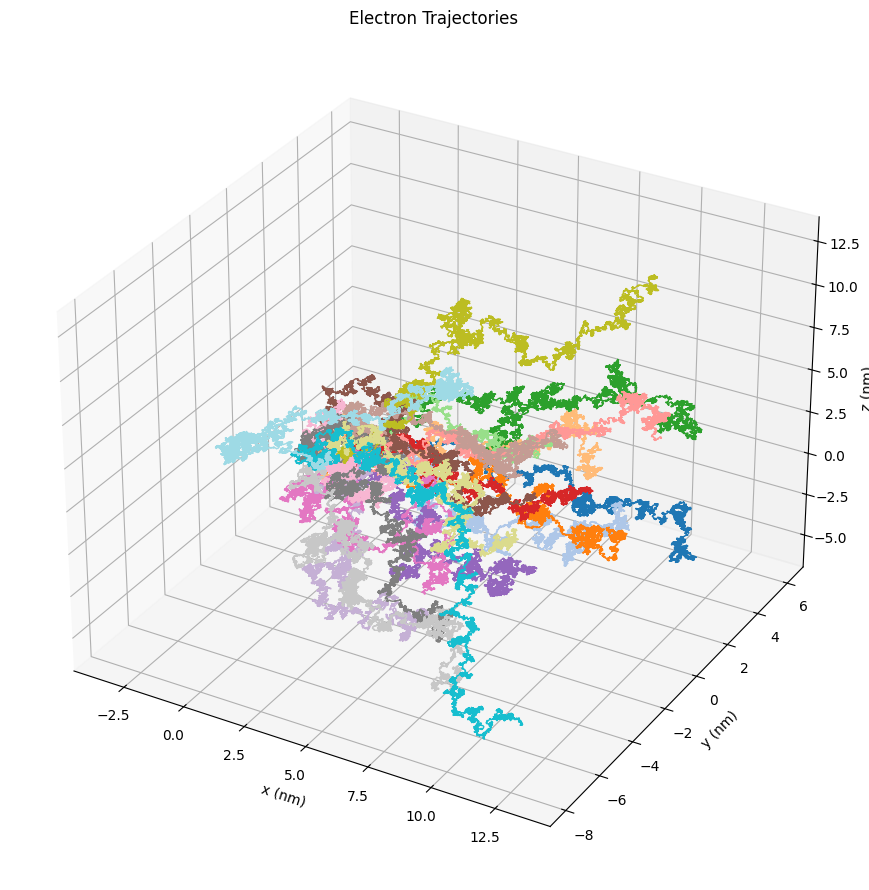

In [9]:
fig = plt.figure(figsize=(11, 9))
ax  = fig.add_subplot(111, projection="3d")

color_cycle = itertools.cycle(plt.cm.tab20.colors)

for key, files in sorted(file_tree.items()):
    for file in files:
        data = np.loadtxt(file, delimiter=",")[::5]          # every 5 th row
        x, y, z = data[:, 1], data[:, 2], data[:, 3]
        col = next(color_cycle)

        ax.plot(x, y, z, lw=1, color=col)

        if len(x) > 1:                                       # arrow at the end
            dx, dy, dz = x[-1] - x[-2], y[-1] - y[-2], z[-1] - z[-2]
            ax.quiver(
                x[-2], y[-2], z[-2],
                dx,    dy,    dz,
                color=col,
                arrow_length_ratio=0.2,
                linewidth=1
            )

ax.set_title("Electron Trajectories")
ax.set_xlabel("x (nm)")
ax.set_ylabel("y (nm)")
ax.set_zlabel("z (nm)")

plt.tight_layout()
plt.show()


## Recombination Analysis


In [10]:

avg_y = 0.0

# Distance in microns between each argon
r_k = 0.075      # µm   

angle = 40         # degrees
rad   = np.deg2rad(angle)
cosA, sinA = np.cos(rad), np.sin(rad)

# Maximum distance in x-direction
r_max = 5.0

# Number of positions (Change manually if needed)
N = 20

def extract_coordinates(file, electron_key):
    with open(file, 'r') as f:
        ke_column = []
        results   = []
        row_list  = []

        lines      = f.readlines()
        num_lines  = len(lines)


        for i in range(0, num_lines, 1):
            cols = list(map(float, filter(None, lines[i].strip().split(','))))
            x, y, z, ke = cols[1], cols[2], cols[3], cols[5]
            row_number  = i

            if not ke_column:
                ke_column.append(ke)

            # --------- distance to nearest tilted ion -------------------
            # Projection of (x,z) onto the tilted ion line
            s_proj = x * cosA + z * sinA          # signed µm

            # Closest lattice site coordinate along the line
            s_near = round(s_proj / r_k) * r_k

            # Ion coordinates
            x_i = s_near * cosA
            z_i = s_near * sinA

            # Euclidean distance to that ion
            closest_distance = np.sqrt((x - x_i)**2 + y**2 + (z - z_i)**2)
            # ------------------------------------------------------------

            # Recombination or escape logic
            if x > r_max:
                results.append(1)
                row_list.append(row_number)
            elif closest_distance < 0.001229 and ke < 1.0:
                results.append(-1)
                row_list.append(row_number)
            else:
                results.append(0)

    return results, row_list




# Lists to store overall results
all_results = []
occurence_list = []
file_row_list = {}

electron_index = 0

for key, value in sorted(file_tree.items()):
    print(key)
    for file in value:
        electron_key = f'electron_{electron_index}'
        
        # UNPACK the two returns properly:
        results_list, row_list = extract_coordinates(file, electron_key)
        
        # Now 'results_list' is the integer list [-1, 0, 1], not a tuple.
        all_results.append(results_list)
        
        # Count occurrences of -1 and 1
        num_minus_1 = results_list.count(-1)
        num_1       = results_list.count(1)
        
        # Save row_list if desired
        file_row_list[file] = row_list
        
        # Determine outcome
        if 1 in results_list:
            if -1 not in results_list:
                outcome = "escapes"
                occurence_list.append(1)
            else:
                first_index_1 = results_list.index(1)
                first_index_minus_1 = results_list.index(-1)
                if first_index_1 < first_index_minus_1:
                    outcome = "escapes"
                    occurence_list.append(1)
                else:
                    outcome = "recombines"
                    occurence_list.append(-1)
        elif -1 in results_list:
            outcome = "recombines"
            occurence_list.append(-1)
        else:
            outcome = "undetermined"
            occurence_list.append(0)

        # Print
        print(f"File: {file}")
        print(f"Outcome: {outcome}")

        electron_index += 1

# Print the occurrence list
print("Occurrence List:", occurence_list)

# Probability
prob_recomb = occurence_list.count(-1)/len(occurence_list)
prob_escape = occurence_list.count(1)/len(occurence_list)

print("Escape Probability:", prob_escape, "Recombination Probability:", prob_recomb)


500
File: simulation-runs/500V_1.txt
Outcome: recombines
File: simulation-runs/500V_2.txt
Outcome: escapes
File: simulation-runs/500V_3.txt
Outcome: escapes
File: simulation-runs/500V_4.txt
Outcome: escapes
File: simulation-runs/500V_5.txt
Outcome: recombines
File: simulation-runs/500V_6.txt
Outcome: recombines
File: simulation-runs/500V_7.txt
Outcome: escapes
File: simulation-runs/500V_8.txt
Outcome: escapes
File: simulation-runs/500V_9.txt
Outcome: escapes
File: simulation-runs/500V_10.txt
Outcome: escapes
File: simulation-runs/500V_11.txt
Outcome: escapes
File: simulation-runs/500V_12.txt
Outcome: escapes
File: simulation-runs/500V_13.txt
Outcome: escapes
File: simulation-runs/500V_14.txt
Outcome: undetermined
File: simulation-runs/500V_15.txt
Outcome: escapes
File: simulation-runs/500V_16.txt
Outcome: recombines
File: simulation-runs/500V_17.txt
Outcome: escapes
File: simulation-runs/500V_18.txt
Outcome: escapes
File: simulation-runs/500V_19.txt
Outcome: escapes
File: simulation-ru